### Setup the Environment and Load the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import branchpro
import scipy.stats
import scipy.special
from branchpro.apps import ReproductionNumberPlot
import nest_asyncio
import plotly.graph_objs as go
import plotly.io as pio
nest_asyncio.apply()

In [2]:
data_path = 'NI_summarised_data/'

In [3]:
incidences_true_r1 = pd.read_csv(data_path + 'radius_1/seir_EI.csv')['Incidence (E)']
incidences_true_r02 = pd.read_csv(data_path + 'radius_0_2/seir_EI.csv')['Incidence (E)']

### Read True Incidences from Output of EpiABM

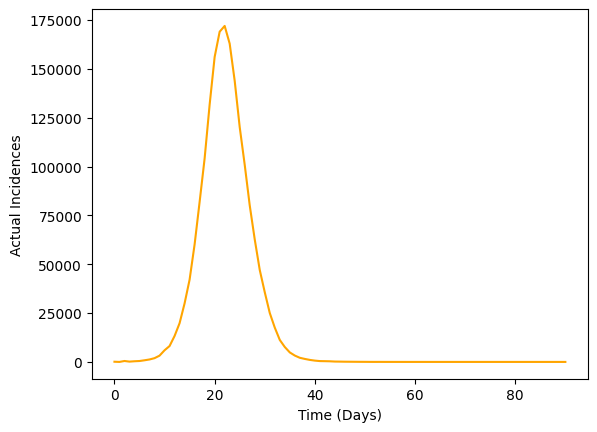

In [4]:
plt.figure()
plt.plot(incidences_true_r1, color='orange')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Incidences')
plt.show()

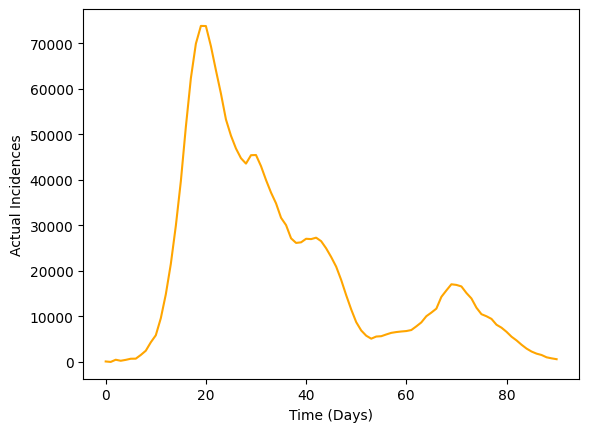

In [5]:
plt.figure()
plt.plot(incidences_true_r02, color='orange')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Incidences')
plt.show()

### Read in True $R_{t}$ series

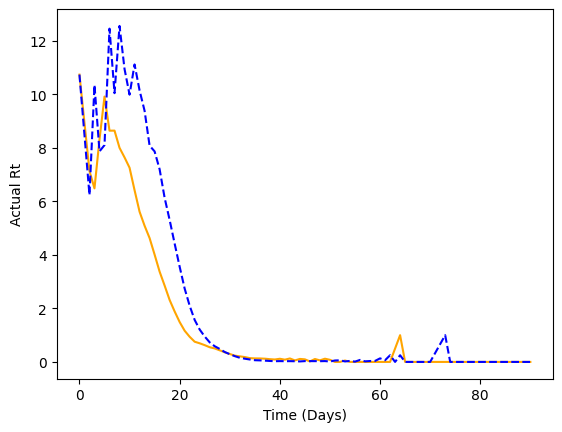

In [6]:
# Radius = 1
true_rt_r1_E = np.load(data_path + 'radius_1/interpolated_Rt_E.npy')
true_rt_r1_I = np.load(data_path + 'radius_1/interpolated_Rt_I.npy')

plt.plot(true_rt_r1_E, color='orange')
plt.plot(true_rt_r1_I, color='blue', linestyle='dashed')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Rt')
plt.show()

true_rt_r1 = true_rt_r1_E

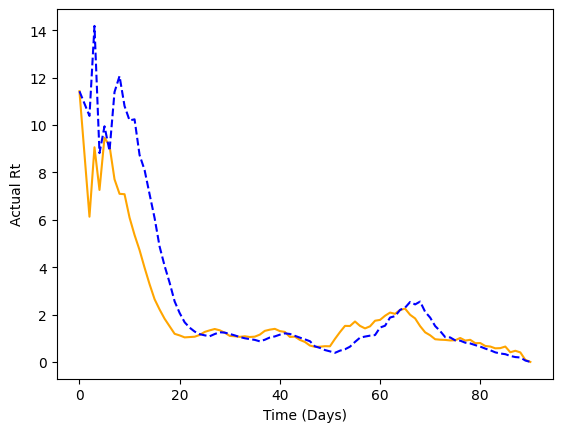

In [7]:
# Radius = 0.2
true_rt_r02_E = np.load(data_path + 'radius_0_2/interpolated_Rt_E.npy')
true_rt_r02_I = np.load(data_path + 'radius_0_2/interpolated_Rt_I.npy')

plt.plot(true_rt_r02_E, color='orange')
plt.plot(true_rt_r02_I, color='blue', linestyle='dashed')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Rt')
plt.show()

true_rt_r02 = true_rt_r02_E

### Calculate the serial interval and generation time from the synthetic data

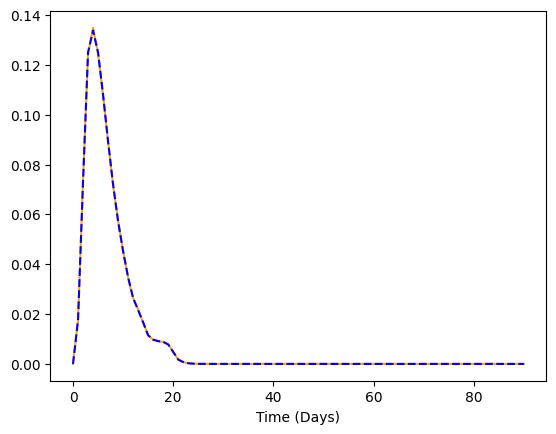

In [8]:
serial_interval_r1 = np.load(data_path + 'radius_1/serial_interval_pdf.npy')
serial_interval_r02 = np.load(data_path + 'radius_0_2/serial_interval_pdf.npy')
plt.plot(serial_interval_r1, color='orange')
plt.plot(serial_interval_r02, color='blue', linestyle = '--')
plt.xlabel('Time (Days)')
plt.show()

serial_interval = serial_interval_r1

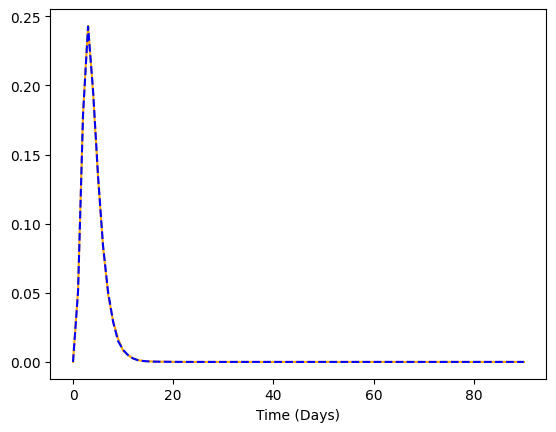

In [9]:
generation_time_r1 = np.load(data_path + 'radius_1/generation_time_pdf.npy')
generation_time_r02 = np.load(data_path + 'radius_0_2/generation_time_pdf.npy')
plt.plot(generation_time_r1, color='orange')
plt.plot(generation_time_r02, color='blue', linestyle='--')
plt.xlabel('Time (Days)')
plt.show()

generation_time = generation_time_r1

### Make the $R_t$ prediction using Generation Time

In [10]:
import scipy.integrate as si
def Rt_inst_to_Rt_case(Rt_inst, f, t_start, t_end):
    """Converts the instantaneous reproduction number to the case reproduction number
    at time t, given a generation time/serial interval distribution, f.
    """
    Rt_case = []
    dx = 1
    for t in range(t_end - t_start):
        Rt_case_t = si.simpson(Rt_inst[t:] * (f[:t_end-t_start-t]), x=np.arange(t + t_start, t_end, 1.0))
        Rt_case.append(Rt_case_t)
    return Rt_case

In [11]:
def process_intervals_data(intervals, generation_time):
    interval_mean = intervals['Mean'].to_numpy()
    interval_lower = intervals['Lower bound CI'].to_numpy()
    interval_upper = intervals['Upper bound CI'].to_numpy()
    interval_mean = Rt_inst_to_Rt_case(interval_mean, generation_time, 0, len(interval_mean))
    interval_lower = Rt_inst_to_Rt_case(interval_lower, generation_time, 0, len(interval_mean))
    interval_upper = Rt_inst_to_Rt_case(interval_upper, generation_time, 0, len(interval_mean))
    intervals['Mean'] = interval_mean
    intervals['Lower bound CI'] = interval_lower
    intervals['Upper bound CI'] = interval_upper

    return intervals

In [12]:
def plot_rt_fig(intervals, true_rt, generation_time, end_time_point, starting_time_point=0):
    fig = ReproductionNumberPlot()

    fig.add_interval_rt(intervals)
    true_rt_plot = go.Scatter(
        y=true_rt[starting_time_point:end_time_point],
        x=list(range(starting_time_point, end_time_point)),
        mode='lines',
        name='Actual R_t',
        line_color='green'
    )

    fig.figure.add_trace(true_rt_plot)
    fig.update_labels(time_label='Time (Day)', r_label='R_t')
    return fig

In [ ]:
# Use incidence data to predict R_t value
theta = incidences_true_r1
end_time_point = len(theta)
# Define variables needed for calculating R_t
tau = 0
R_t_start = tau+1
prior_a = 1
prior_b = 1/5

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)-2),
        'Incidence Number': incidences_true_r1[2:len(theta)]
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=generation_time,
    alpha=prior_a,
    beta=prior_b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)
intervals = process_intervals_data(intervals, generation_time)

intervals['True Rt'] = list(true_rt_r1[3:])
intervals.to_csv('single_plots/intervals_r1.csv')


fig = plot_rt_fig(intervals, true_rt_r1[2:-1], generation_time, end_time_point)
pio.write_image(fig.figure, 'single_plots/predicted_vs_true_rt_r1.png')
fig.show_figure()

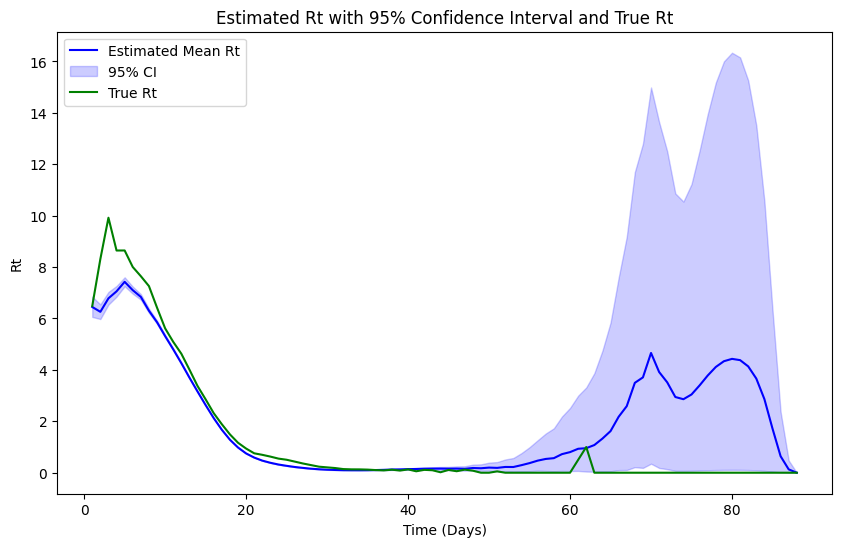

In [ ]:
# Load intervals dataframe
intervals = pd.read_csv('single_plots/intervals_r1.csv')

# Plot the mean series over time with shaded area for upper and lower bounds
plt.figure(figsize=(10, 6))
plt.plot(intervals['Time Points'], intervals['Mean'], label='Estimated Mean Rt', color='blue')
plt.fill_between(intervals['Time Points'], intervals['Lower bound CI'], intervals['Upper bound CI'], color='blue', alpha=0.2, label='95% CI')
plt.plot(intervals['Time Points'], intervals['True Rt'], label='True Rt', color='green', linestyle='solid')

plt.xlabel('Time (Days)')
plt.ylabel('Rt')
plt.legend()
plt.title('Estimated Rt with 95% Confidence Interval and True Rt')
plt.show()

In [ ]:
# Use incidence data to predict R_t value
theta = incidences_true_r02
starting_time_point = 0
end_time_point = len(theta)
# Define variables needed for calculating R_t
tau = 0
R_t_start = tau+1

# Plot comparison between the true and predicted R_t
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)-2),
        'Incidence Number': incidences_true_r02[2:len(theta)]
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=generation_time,
    alpha=prior_a,
    beta=prior_b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)
intervals = process_intervals_data(intervals, generation_time)

intervals['True Rt'] = true_rt_r02[3:]
intervals.to_csv('single_plots/intervals_r02.csv')


fig = plot_rt_fig(intervals, true_rt_r02[2:-1], generation_time, end_time_point)
pio.write_image(fig.figure, 'single_plots/predicted_vs_true_rt_r02.png')
fig.show_figure()

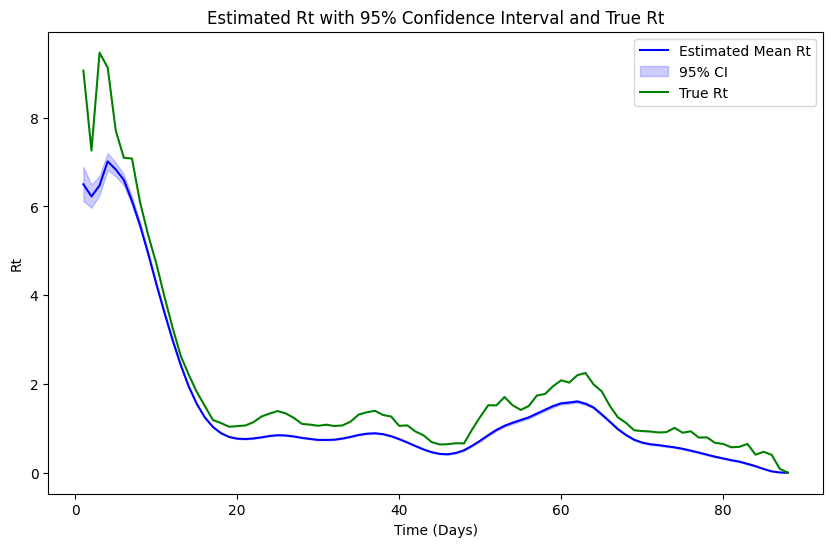

In [ ]:
# Load intervals dataframe
intervals = pd.read_csv('single_plots/intervals_r02.csv')

# Plot the mean series over time with shaded area for upper and lower bounds
plt.figure(figsize=(10, 6))
plt.plot(intervals['Time Points'], intervals['Mean'], label='Estimated Mean Rt', color='blue')
plt.fill_between(intervals['Time Points'], intervals['Lower bound CI'], intervals['Upper bound CI'], color='blue', alpha=0.2, label='95% CI')
plt.plot(intervals['Time Points'], intervals['True Rt'], label='True Rt', color='green', linestyle='solid')

plt.xlabel('Time (Days)')
plt.ylabel('Rt')
plt.legend()
plt.title('Estimated Rt with 95% Confidence Interval and True Rt')
plt.show()

## Sensitivity analysis

Fit the generation time we use to a gamma distribution. Then conduct inference using this distribution, along with two other distributions with modified means for the generation time

In [17]:
from scipy.stats import gamma
from scipy.optimize import curve_fit

Fitted parameters: a = 3.67, loc = 0.27, scale = 1.01


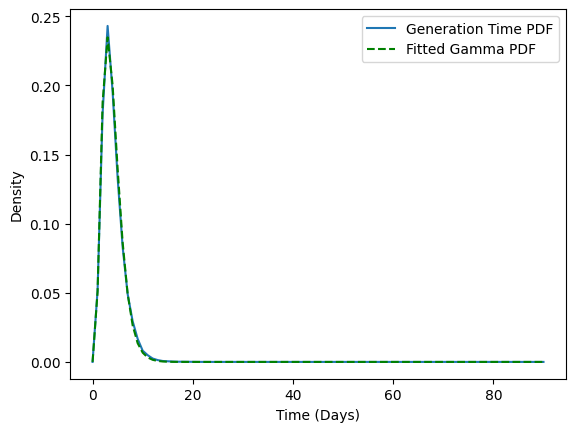

In [18]:
x = np.arange(0, len(generation_time_r1), 1)
y = generation_time_r1

popt, pcov = curve_fit(gamma.pdf, x, y, p0=[1, 0, 1])
gamma_a, gamma_loc, gamma_scale = popt
print(f"Fitted parameters: a = {gamma_a:.2f}, "
      + f"loc = {gamma_loc:.2f}, scale = {gamma_scale:.2f}")

fitted_gamma_pdf = gamma.pdf(x, gamma_a, gamma_loc, gamma_scale)

plt.plot(generation_time, label='Generation Time PDF')
plt.plot(x, fitted_gamma_pdf, 'g--', label='Fitted Gamma PDF')
plt.xlabel('Time (Days)'); plt.ylabel('Density')
plt.legend(); plt.show()

In [19]:
def plot_multi_rt_fig(intervals_list, true_rt, generation_time, end_time_point, starting_time_point=0):
    fig = ReproductionNumberPlot()

    colors = plt.cm.viridis(np.linspace(0, 0.5, len(intervals_list)))
    colors = [str(mcolors.rgb2hex(c)) for c in colors]
    
    for n in range(len(intervals_list)):
        intervals = intervals_list[n]
        intervals = process_intervals_data(intervals.copy(), generation_time)

        fig.add_interval_rt(intervals, colour=colors[n])
        fig.update_labels(time_label='Time (Day)', r_label='R_t')
    
    true_rt_plot = go.Scatter(
        y=true_rt[starting_time_point:end_time_point],
        x=list(range(starting_time_point, end_time_point)),
        mode='lines',
        name='Actual R_t',
        line_color='black'
    )

    fig.figure.add_trace(true_rt_plot)
    
    return fig

Given:

Original mean: $\mu = a \cdot b$
Original variance: $\sigma^2 = a \cdot b^2$
We want:

New mean: $\mu' = a' \cdot b' = \mu + 1$
New variance: $\sigma^2 = a' \cdot b'^2$
From the variance equation, we have: $[ a \cdot b^2 = a' \cdot b'^2 ]$

To find $a'$ and $b'$, we can use the following steps:

Express $a'$ in terms of $a$ and $b'$: $[ a' = \frac{a \cdot b^2}{b'^2} ]$

Substitute $a'$ into the new mean equation: [$ \left(\frac{a \cdot b^2}{b'^2}\right) \cdot b' = a \cdot b + 1 ]$

Simplify the equation: $[ \frac{a \cdot b^2 \cdot b'}{b'^2} = a \cdot b + 1 ] [ \frac{a \cdot b^2}{b'} = a \cdot b + 1 ]$

Solve for $b'$: $[ b' = \frac{a \cdot b^2}{a \cdot b + 1} ]$

Substitute $b'$ back to find $a'$: $[ a' = \frac{a \cdot b^2}{\left(\frac{a \cdot b^2}{a \cdot b + 1}\right)^2} ] [ a' = \frac{a \cdot b^2 \cdot (a \cdot b + 1)^2}{a^2 \cdot b^4} ] [ a' = \frac{(a \cdot b + 1)^2}{a \cdot b^2} ]$

So, the new parameters $a'$ and $b'$ are: $[ a' = \frac{(a \cdot b + 1)^2}{a \cdot b^2} ] [ b' = \frac{a \cdot b^2}{a \cdot b + 1} ]$

These adjustments will shift the mean of the distribution by 1 without changing the variance.

In [ ]:
# Use incidence data to predict R_t value
theta = incidences_true_r1
end_time_point = len(theta)

a = gamma_a; b = gamma_scale
gamma_shape_list = [(a*b-1)**2/(a*b*b), a, (a*b+1)**2/(a*b*b)]
gamma_scale_list = [(a*b*b)/(a*b-1), b, (a*b*b)/(a*b+1)]

inc_data_r1 = pd.DataFrame(
    {
        'Time': np.arange(len(theta)-2),
        'Incidence Number': incidences_true_r1[2:len(theta)]
    }
)

intervals_list_r1 = []
for shape, scale in zip(gamma_shape_list, gamma_scale_list):
    gamma_pdf = gamma.pdf(x, shape, gamma_loc, scale)
    inference = branchpro.BranchProPosterior(
        inc_data=inc_data_r1,
        daily_serial_interval=gamma_pdf,
        alpha=prior_a,
        beta=prior_b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    intervals_list_r1.append(intervals)

fig = plot_multi_rt_fig(intervals_list_r1, true_rt_r1[2:-1], gamma_pdf, end_time_point)

n = 0
for i, handle in enumerate(fig.figure['data']):
    if handle['name'].startswith('Estimated'):
        mean_val = gamma_shape_list[n]*gamma_scale_list[n]
        handle['name'] = "$R_{t}$, " + f'gamma mean = {mean_val:.2g} days'
        n += 1

pio.write_image(fig.figure, 'single_plots/predicted_vs_true_rt_r1_multi.png')  
fig.show_figure()

/home/gallagher/Documents/covid_work/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



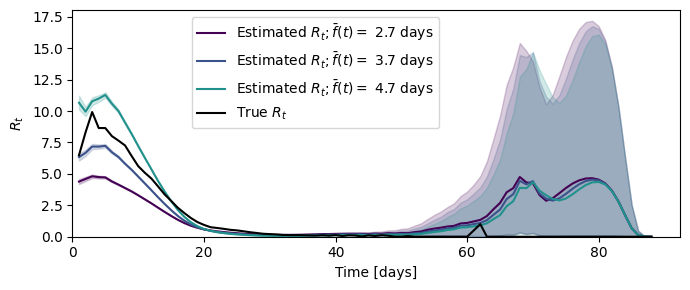

In [ ]:
plt.figure(figsize=(7, 3))

colors = plt.cm.viridis(np.linspace(0, 0.5, len(intervals_list_r1)))
colors = [str(mcolors.rgb2hex(c)) for c in colors]

for n in range(len(intervals_list_r1)):
    intervals = intervals_list_r1[n]
    intervals = process_intervals_data(intervals.copy(), gamma_pdf)

    plt.plot(intervals['Time Points'], intervals['Mean'], color=colors[n], 
             label=r'Estimated $R_{t}; \bar{f}(t) = $' + f' {gamma_shape_list[n]*gamma_scale_list[n]:.2g} days')
    plt.fill_between(intervals['Time Points'], intervals['Lower bound CI'], intervals['Upper bound CI'], 
                     color=colors[n], alpha=0.2)


plt.plot(intervals['Time Points'], true_rt_r1[3:], label='True $R_{t}$', color='k', linestyle='solid')

plt.xlabel('Time [days]'); plt.ylabel('$R_{t}$')
plt.xlim(left=0); plt.ylim(bottom=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1))
plt.tight_layout()
plt.savefig('single_plots/estimated_vs_true_rt_r1_multi_plt.png', dpi=600)
plt.show()

In [ ]:
# Use incidence data to predict R_t value
theta = incidences_true_r02
end_time_point = len(theta)

inc_data_r02 = pd.DataFrame(
    {
        'Time': np.arange(len(theta)-2),
        'Incidence Number': incidences_true_r02[2:len(theta)]
    }
)

intervals_list_r02 = []
for shape, scale in zip(gamma_shape_list, gamma_scale_list):
    gamma_pdf = gamma.pdf(x, shape, gamma_loc, scale)
    inference = branchpro.BranchProPosterior(
        inc_data=inc_data_r02,
        daily_serial_interval=gamma_pdf,
        alpha=prior_a,
        beta=prior_b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    intervals_list_r02.append(intervals)

fig = plot_multi_rt_fig(intervals_list_r02, true_rt_r02[2:-1], gamma_pdf, end_time_point)

n = 0
for i, handle in enumerate(fig.figure['data']):
    if handle['name'].startswith('Estimated'):
        mean_val = gamma_shape_list[n]*gamma_scale_list[n]
        handle['name'] = f'R_t, gamma mean = {mean_val:.2g} days'
        n += 1
   
pio.write_image(fig.figure, 'single_plots/predicted_vs_true_rt_r02_multi.pdf') 
fig.show_figure()

/home/gallagher/Documents/covid_work/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



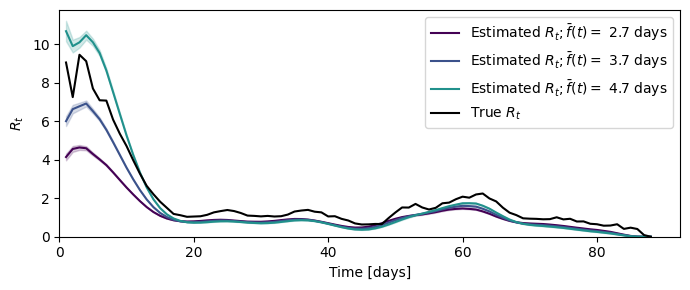

In [ ]:
plt.figure(figsize=(7, 3))

colors = plt.cm.viridis(np.linspace(0, 0.5, len(intervals_list_r1)))
colors = [str(mcolors.rgb2hex(c)) for c in colors]

for n in range(len(intervals_list_r1)):
    intervals = intervals_list_r02[n]
    intervals = process_intervals_data(intervals.copy(), gamma_pdf)

    plt.plot(intervals['Time Points'], intervals['Mean'], color=colors[n], 
             label=r'Estimated $R_{t}; \bar{f}(t) = $' + f' {gamma_shape_list[n]*gamma_scale_list[n]:.2g} days')
    plt.fill_between(intervals['Time Points'], intervals['Lower bound CI'], intervals['Upper bound CI'], 
                     color=colors[n], alpha=0.2)


plt.plot(intervals['Time Points'], true_rt_r02[3:], label='True $R_{t}$', color='k', linestyle='solid')

plt.xlabel('Time [days]'); plt.ylabel('$R_{t}$')
plt.xlim(left=0); plt.ylim(bottom=0)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('single_plots/estimated_vs_true_rt_r02_multi_plt.png', dpi=600)
plt.show()

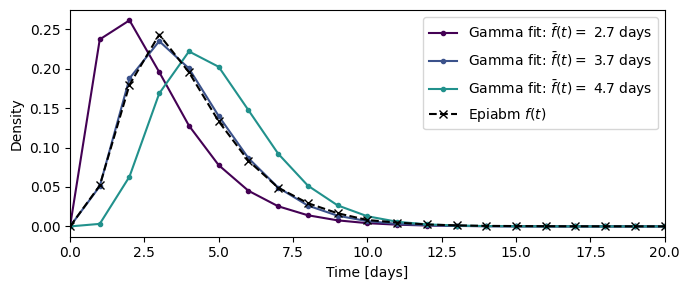

In [ ]:
plt.figure(figsize=(7, 3))
for n, (shape, scale) in enumerate(zip(gamma_shape_list, gamma_scale_list)):
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(gamma_shape_list)))
    colors = [str(mcolors.rgb2hex(c)) for c in colors]

    gamma_pdf = gamma.pdf(x, shape, gamma_loc, scale)
    plt.plot(gamma_pdf, label=r'Gamma fit: $\bar{f}(t) = $' + f' {gamma_shape_list[n]*gamma_scale_list[n]:.2g} days',
             color = colors[n], marker='.')


plt.plot(generation_time, label='Epiabm $f(t)$', color='black', linestyle='--', marker='x')
plt.xlabel('Time [days]'); plt.ylabel('Density'); plt.xlim(0, 20)
plt.tight_layout();
plt.legend(); plt.savefig('single_plots/varied_gamma_pdf.png', dpi=600)
plt.show()

In [ ]:
names = ['varied_gamma_pdf.png',
         'estimated_vs_true_rt_r1_multi_plt.png',
         'estimated_vs_true_rt_r02_multi_plt.png']
paths = ['single_plots/' + name for name in names]

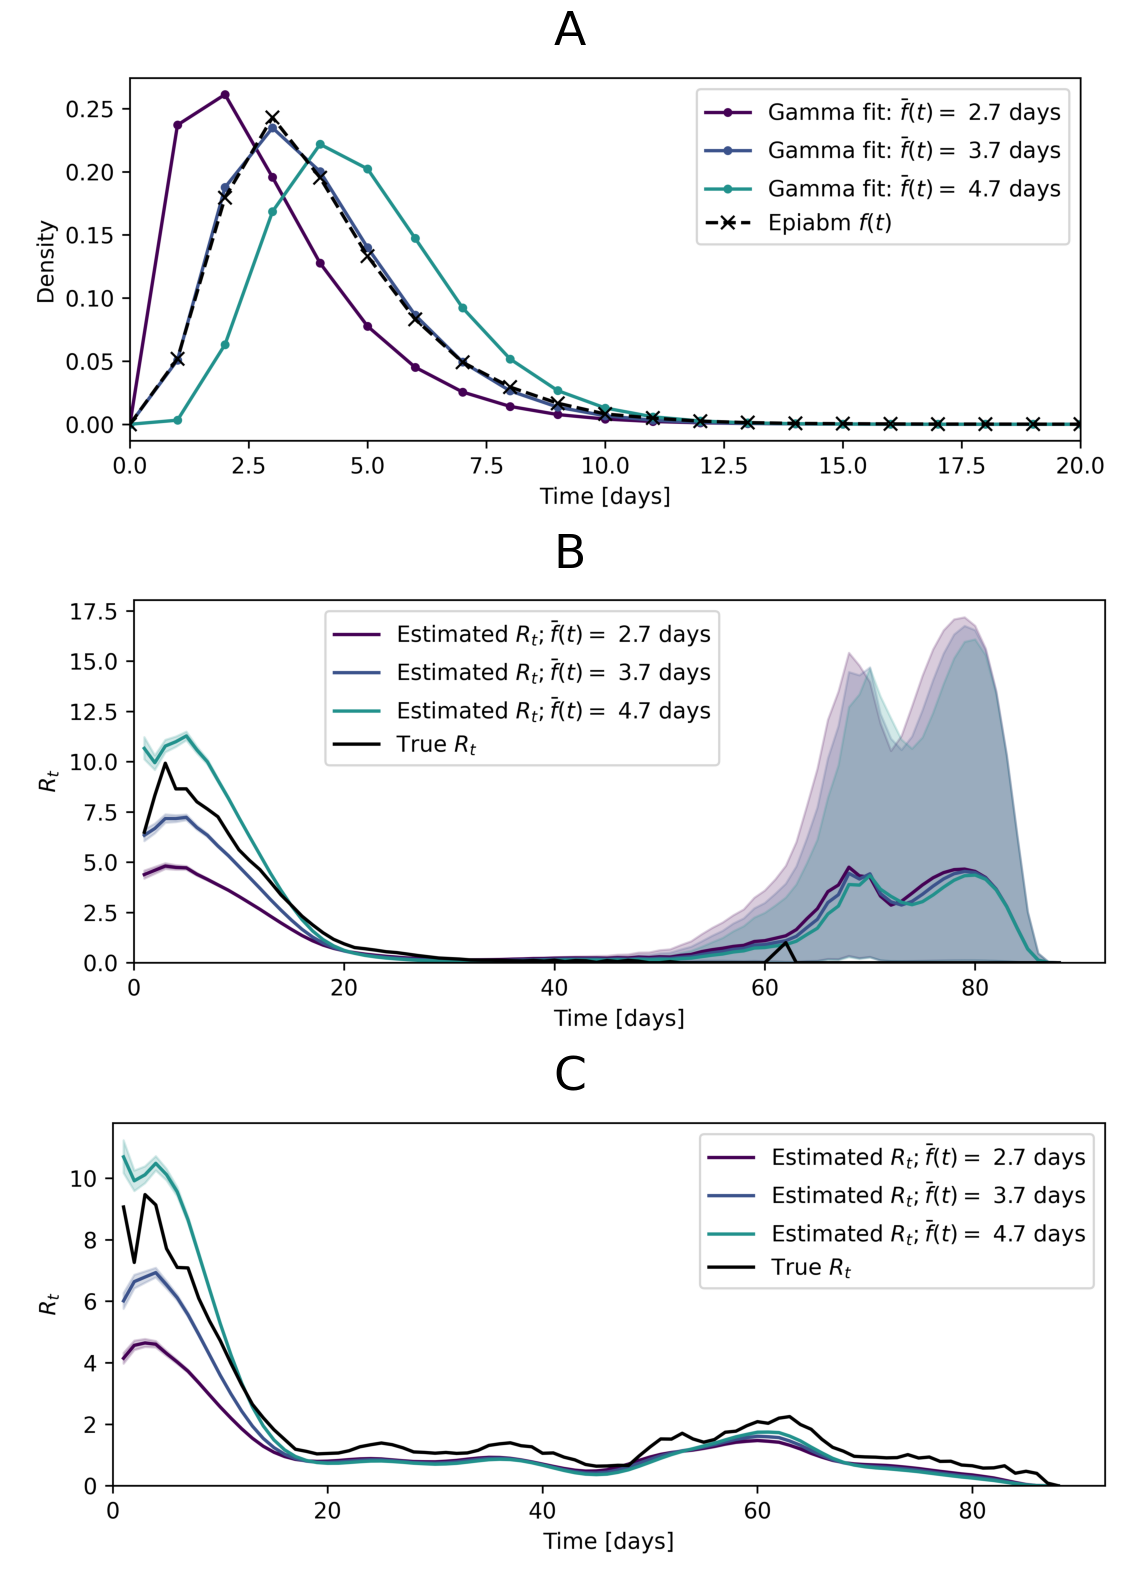

In [26]:
from matplotlib import image

fig = plt.figure(figsize=(24,16))
fig.add_subplot(3, 1, 1)
fig.add_subplot(3, 1, 2)
fig.add_subplot(3, 1, 3)
axs = fig.get_axes()
labels = ["A", "B", "C"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(labels[i], fontsize=34, pad=-90)
    img = image.imread(paths[i])
    ax.imshow(img)
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.09)
fig.savefig("panels/si_figure_8.pdf", bbox_inches="tight", dpi=600)

### Full fitting

Can we define a function that takes the gamma params and outputs the rms error of the estimated Rt.
Then optimise the function for the best gamma params
Finally plot the best estimated Rt (hopefully should fit really well) and also plot the best gamma distribution.

In [27]:
from scipy.optimize import minimize

def gamma_inference_wrapper(gamma_shape, gamma_loc, gamma_scale, inc_data, true_rt, start_delay=5):
    gamma_pdf = gamma.pdf(x, gamma_shape, gamma_loc, gamma_scale)
    inference = branchpro.BranchProPosterior(
        inc_data=inc_data,
        daily_serial_interval=gamma_pdf,
        alpha=prior_a,
        beta=prior_b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    interval_mean = intervals['Mean'].to_numpy()

    rms_error = np.sqrt(np.mean((interval_mean[start_delay:] - true_rt[start_delay + 2:-1])**2))
    return rms_error

In [28]:
inc_data_r1_trunc = pd.DataFrame(
    {
        'Time': np.arange(40),
        'Incidence Number': incidences_true_r1[2:42]
    }
)
true_rt_r1_trunc = true_rt_r1[2:44]

In [29]:
def objective(params):
    gamma_shape, gamma_loc, gamma_scale = params
    return gamma_inference_wrapper(gamma_shape, gamma_loc, gamma_scale, 
                                   inc_data_r1, true_rt_r1, start_delay=5)

initial_guess = [gamma_a, gamma_loc, gamma_scale]
result_r1 = minimize(objective, initial_guess, method='nelder-mead')

print(f"Optimal parameters: shape = {result_r1.x[0]}, loc = {result_r1.x[1]}, scale = {result_r1.x[2]}")

Optimal parameters: shape = 1.0271938767167659, loc = -3.0522941671235366e-12, scale = 6.517393127840855


In [ ]:
gamma_pdf_opt_r1 = gamma.pdf(x, result_r1.x[0], result_r1.x[1], result_r1.x[2])
inference = branchpro.BranchProPosterior(
    inc_data=inc_data_r1,
    daily_serial_interval=gamma_pdf_opt_r1,
    alpha=prior_a,
    beta=prior_b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)
intervals = process_intervals_data(intervals, gamma_pdf_opt_r1)

fig = plot_rt_fig(intervals, true_rt_r1[2:-1], gamma_pdf_opt_r1, end_time_point)
pio.write_image(fig.figure, 'single_plots/predicted_vs_true_rt_r1_optimal.png')
fig.show_figure()

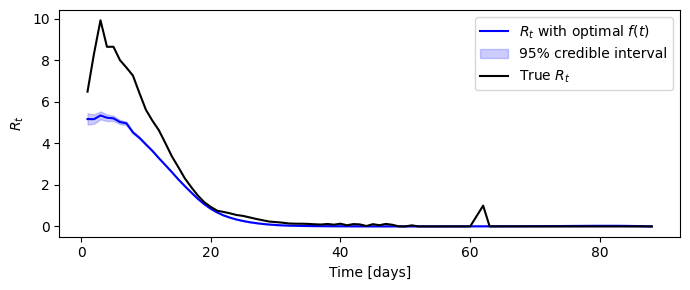

In [ ]:
# Plot the mean series over time with shaded area for upper and lower bounds
plt.figure(figsize=(7, 3))
plt.plot(intervals['Time Points'], intervals['Mean'], label='$R_{t}$ with optimal $f(t)$', color='b')
plt.fill_between(intervals['Time Points'], intervals['Lower bound CI'], intervals['Upper bound CI'], 
                 color='b', alpha=0.2, label='95% credible interval')
plt.plot(intervals['Time Points'], true_rt_r1[3:], label='True $R_{t}$', color='k', linestyle='solid')

plt.xlabel('Time [days]')
plt.ylabel('$R_{t}$')
plt.legend()
plt.tight_layout()
plt.savefig('single_plots/estimated_vs_true_rt_r1_optimal.png', dpi=600)
plt.show()

In [32]:
def objective(params):
    gamma_shape, gamma_loc, gamma_scale = params
    return gamma_inference_wrapper(gamma_shape, gamma_loc, gamma_scale, 
                                   inc_data_r02, true_rt_r02, start_delay=5)

result_r02 = minimize(objective, initial_guess, method='Nelder-Mead')

print(f"Optimal parameters: shape = {result_r02.x[0]}, loc = {result_r02.x[1]}, scale = {result_r02.x[2]}")

Optimal parameters: shape = 55.29487317432893, loc = -1.397839118702505, scale = 0.07903074101841678


In [ ]:
gamma_pdf_opt_r02 = gamma.pdf(x, result_r02.x[0], result_r02.x[1], result_r02.x[2])
inference = branchpro.BranchProPosterior(
    inc_data=inc_data_r02,
    daily_serial_interval=gamma_pdf_opt_r02,
    alpha=prior_a,
    beta=prior_b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)
intervals = process_intervals_data(intervals, gamma_pdf_opt_r02)

fig = plot_rt_fig(intervals, true_rt_r02[2:-1], gamma_pdf_opt_r02, end_time_point)
pio.write_image(fig.figure, 'single_plots/predicted_vs_true_rt_r02_optimal.png')
fig.show_figure()

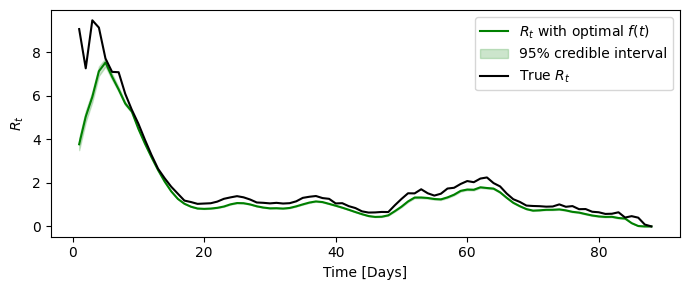

In [ ]:
# Plot the mean series over time with shaded area for upper and lower bounds
plt.figure(figsize=(7, 3))
plt.plot(intervals['Time Points'], intervals['Mean'], label='$R_{t}$ with optimal $f(t)$', color='g')
plt.fill_between(intervals['Time Points'], intervals['Lower bound CI'], intervals['Upper bound CI'], 
                 color='g', alpha=0.2, label='95% credible interval')
plt.plot(intervals['Time Points'], true_rt_r02[3:], label='True $R_{t}$', color='k', linestyle='solid')

plt.xlabel('Time [Days]')
plt.ylabel('$R_{t}$')
plt.legend()
plt.tight_layout()
plt.savefig('single_plots/estimated_vs_true_rt_r02_optimal.png', dpi=600)
plt.show()

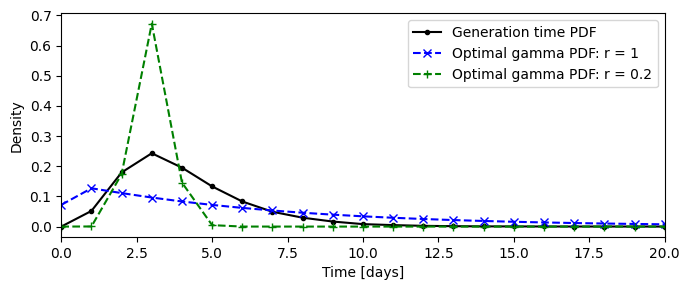

In [ ]:
x = np.arange(0, len(generation_time), 1)
gamma_pdf_plot_r1 = gamma.pdf(x, result_r1.x[0], result_r1.x[1], result_r1.x[2])
gamma_pdf_plot_r02 = gamma.pdf(x, result_r02.x[0], result_r02.x[1], result_r02.x[2])

plt.figure(figsize=(7, 3))
plt.plot(generation_time, marker = '.', color = 'k', label='Generation time PDF')
plt.plot(x, gamma_pdf_plot_r1, 'b--', marker='x', label='Optimal gamma PDF: r = 1')
plt.plot(x, gamma_pdf_plot_r02, 'g--', marker='+', label='Optimal gamma PDF: r = 0.2')
plt.xlabel('Time [days]'); plt.ylabel('Density'); plt.xlim(0, 20)
plt.legend(); plt.tight_layout()
plt.savefig('single_plots/fitted_gamma_pdf.png', dpi=600)
plt.show()

In [ ]:
names = ['fitted_gamma_pdf.png',
         'estimated_vs_true_rt_r1_optimal.png',
         'estimated_vs_true_rt_r02_optimal.png']
paths = ['single_plots/' + name for name in names]

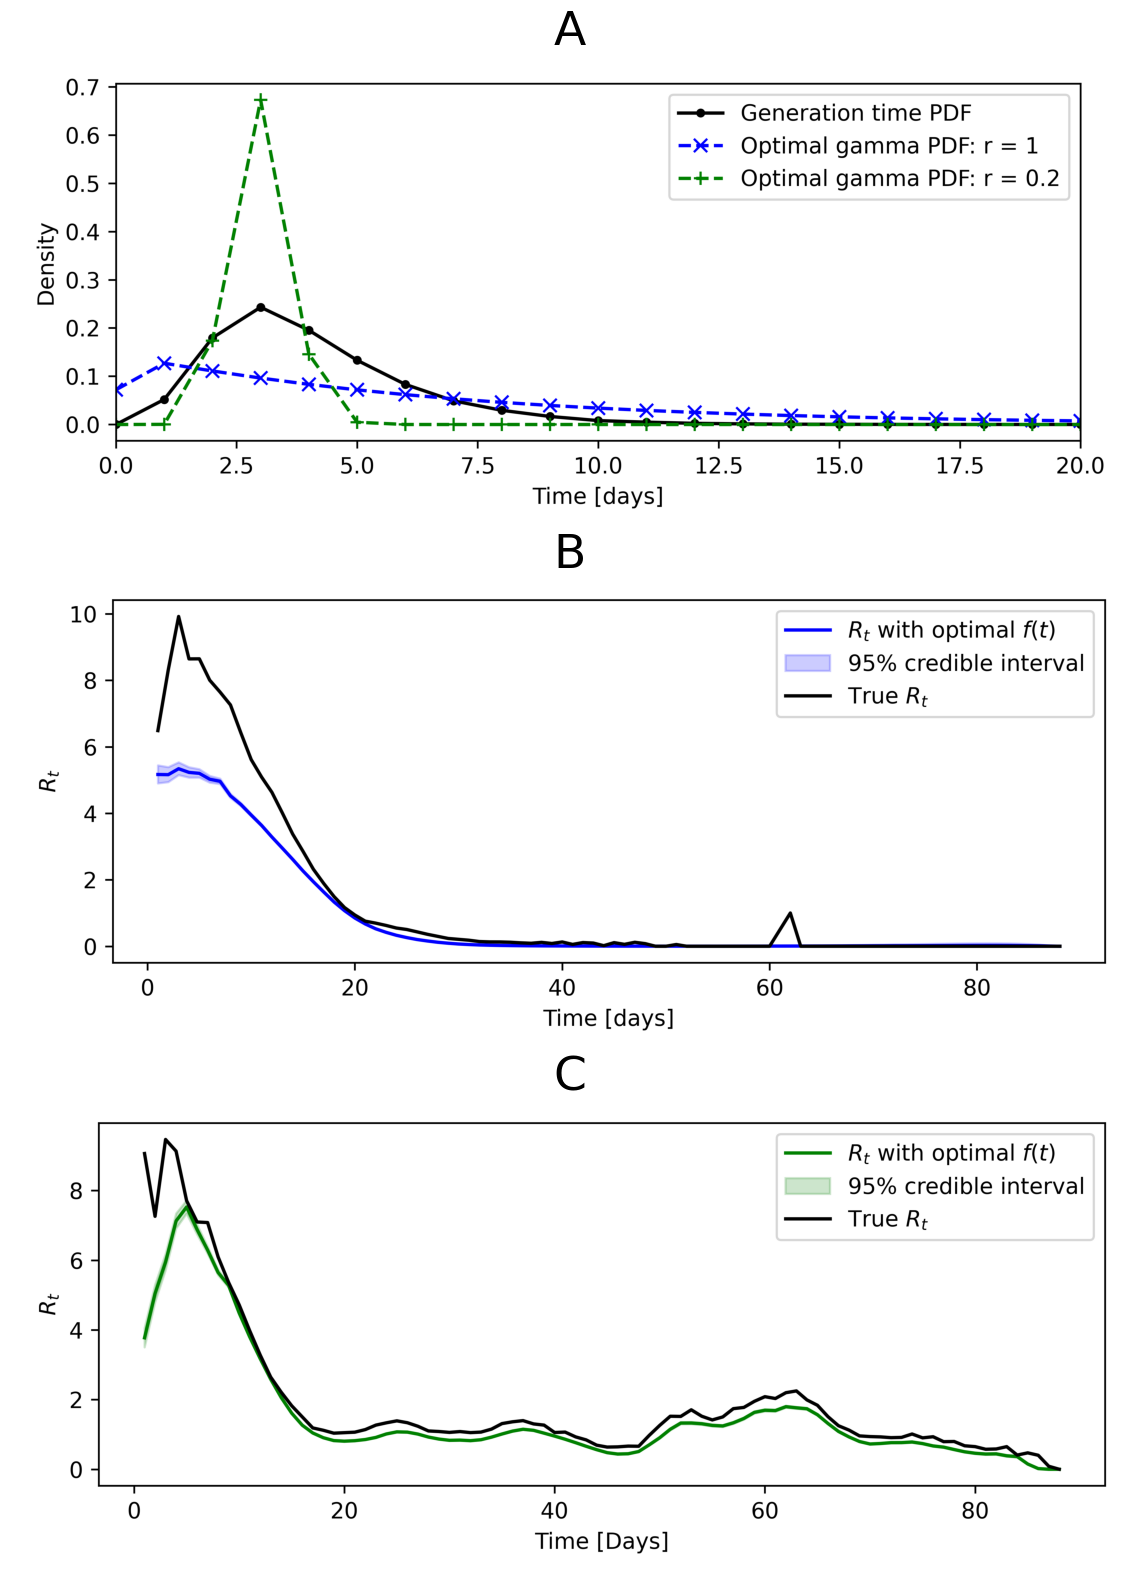

In [37]:
from matplotlib import image

fig = plt.figure(figsize=(24,16))
fig.add_subplot(3, 1, 1)
fig.add_subplot(3, 1, 2)
fig.add_subplot(3, 1, 3)
axs = fig.get_axes()
labels = ["A", "B", "C"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(labels[i], fontsize=34, pad=-90)
    img = image.imread(paths[i])
    ax.imshow(img)
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.09)
fig.savefig("panels/si_figure_9.pdf", bbox_inches="tight", dpi=600)